In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# 定义自编码器模型
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=1)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, kernel_size=5, stride=3, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, kernel_size=2, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [7]:
# 加载 MNIST 数据集
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# 初始化自编码器模型
model = Autoencoder().to(device)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 训练自编码器模型
num_epochs = 10
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        # 前向传播
        output = model(img)
        loss = criterion(output, img)
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/10], Loss: 0.1605
Epoch [2/10], Loss: 0.1349
Epoch [3/10], Loss: 0.1223
Epoch [4/10], Loss: 0.1192
Epoch [5/10], Loss: 0.1147
Epoch [6/10], Loss: 0.1015
Epoch [7/10], Loss: 0.1123
Epoch [8/10], Loss: 0.1108
Epoch [9/10], Loss: 0.0989
Epoch [10/10], Loss: 0.1129


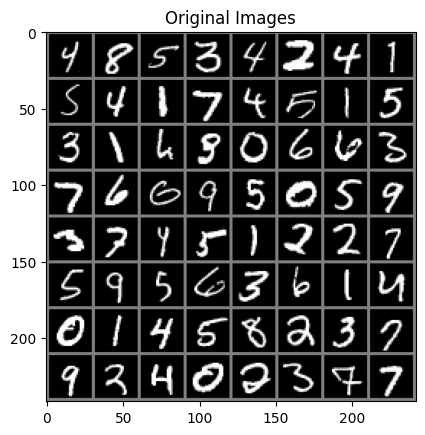

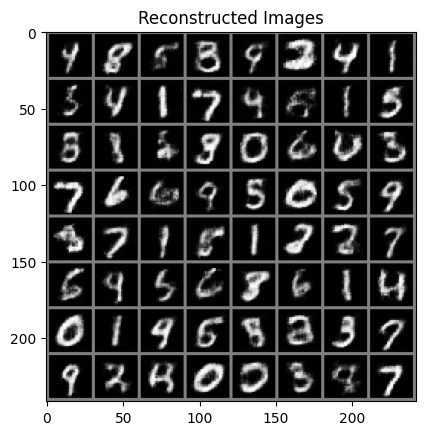

In [8]:
# 测试自编码器模型
import matplotlib.pyplot as plt

# 显示原始图像和重建图像
with torch.no_grad():
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        output = model(img)
        # 显示原始图像
        plt.imshow(torchvision.utils.make_grid(img.cpu()).numpy()[0], cmap='gray')
        plt.title('Original Images')
        plt.show()
        # 显示重建图像
        plt.imshow(torchvision.utils.make_grid(output.cpu()).numpy()[0], cmap='gray')
        plt.title('Reconstructed Images')
        plt.show()
        break  # 仅显示一个 batch 的图像
